# SDG1062X Function Generator as an arbitrary waveform generator. Development of a pyVISA communication library.

- **Author:** Juan del Pino Mena
- **Version:** v03


# Changelog

- **V01 - 01/02/2022 - Juan del Pino Mena**
    - Initial implementation.
    - Methods for sending samples to the arbitrary waveform generator .
- **V02 - 30/03/2022 - Juan del Pino Mena**
    - Implementation of burst commands, to trigger signals at demand.
    - New function to quicky configure and send sample sending from a .csv file to the function generator.
- **V03 - 05/04/2022 - Juan del Pino Mena**
    - English translation.
    - Minor improvements and notebook reorganization.
    - Added pip commands to automatically install requirements
    
## Known issues

- Seems like sending long samples vectors causes the generator to not detect the command termination. This causes the next command to be interpreted as samples and  to output some weird, digital shapes at the end of the desired function. This is paliated by sending inmediately after an empty command with only "\r\n".

---

# Introduction

## Python requirements

- numpy
- matplotlib
- pyvisa


In [10]:
import pip

pip.main(['install', 'numpy'])
pip.main(['install', 'matplotlib'])
pip.main(['install', 'pyvisa'])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
distutils: S:\WinPython\python-3.9.4.amd64\Include\UNKNOWN
sysconfig: S:\WinPython\python-3.9.4.amd64\Include
user = False
home = None
root = None
prefix = None


distutils: S:\WinPython\python-3.9.4.amd64\Include\UNKNOWN
sysconfig: S:\WinPython\python-3.9.4.amd64\Include
user = False
home = None
root = None
prefix = None
You should consider upgrading via the 'S:\WinPython\python-3.9.4.amd64\python.exe -m pip install --upgrade pip' command.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
distutils: S:\WinPython\python-3.9.4.amd64\Include\UNKNOWN
sysconfig: S:\WinPython\python-3.9.4.amd64\Include
user = False
home = None
root = None
prefix = None


distutils: S:\WinPython\python-3.9.4.amd64\Include\UNKNOWN
sysconfig: S:\WinPython\python-3.9.4.amd64\Include
user = False
home = None
root = None
prefix = None
You should consider upgrading via the 'S:\WinPython\python-3.9.4.amd64\python.exe -m pip install --upgrade pip' command.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
distutils: S:\WinPython\python-3.9.4.amd64\Include\UNKNOWN
sysconfig: S:\WinPython\python-3.9.4.amd64\Include
user = False
home = None
root = None
prefix = None


distutils: S:\WinPython\python-3.9.4.amd64\Include\UNKNOWN
sysconfig: S:\WinPython\python-3.9.4.amd64\Include
user = False
home = None
root = None
prefix = None
You should consider upgrading via the 'S:\WinPython\python-3.9.4.amd64\python.exe -m pip install --upgrade pip' command.


0

---


## Function generator network interface configuration

1. Connect the function generator and your PC to the same local network. Some considerations:
    - This library was developed using wired Ethernet LAN cables for both devices.
    - The router and hub on the GranaSat Lab nº 11 has a 192.168.1.0/24 network. If I'm not wrong, the router has not Wi-Fi enabled so it won't work over Wi-Fi (like IMUDS or eduroam). Make sure you are connected to this LAN by typing `ipconfig` (windows), or `ifconfig` or `ip addr` (linux). Your address should be on that network. You may need to deactivate the Wi-Fi connection of your laptop (modern PCs can can use both simultaneously and this can be troublesome).
    - For convenience, this guide sets a fixed IP to the generator and assumes you are using DHCP on your PC. This way, there is no need to figure out what IP is the generator using everytime you power it up.
2. Access the LAN interface setup on the function generator and configure a fixed IP.
    - "Utility" button >> Page 2 >> Interface >> LAN setup 
    - Set IP address to a free IP i.e.: 192.168.1.101
    - Set the subnet mask to: 255.255.255.0 (meaning /24)
    - Gateway: 192.168.1.1
    - Accept. A message pops saying: "Set Up successfully."
    - Make sure DHCP is off.
3. Check if the device is accessible.
    - Do a ping to the device: `ping 192.168.1.101` (windows & linux).
    - [Optional] If you have it installed, nmap can give you some more information about the device. `sudo nmap -O 192.168.1.101` (linux). It should appear as a 'Texas Instruments' network device.

![ping](images/ping.png)
![nmap](images/nmap.png)

## References

[1] SDG Series Arbitrary Waveform Generator Programming Guide. PG02_E04A. Siglent Technologies CO. LTD.

[2] SDG1000X Series Function/Arbitrary Waveform Generator User Manual. UM0201X-E01D. Siglent Technologies CO. LTD.

[3] PyVISA documentation. https://pyvisa.readthedocs.io/en/latest/index.html

### SDG1000X Programming Guide

In [1]:
from IPython.display import IFrame, display
IFrame("./docs/SDG_programming_guide.pdf", width=1000, height=700)

---

# SDG1062X PyVISA communication library

## Library implementation: class.

In [3]:
import pyvisa as visa
import binascii


class SDG1062X:
    """
    Methods to communicate with the Siglent SDG1062X arbitrary waveform 
    generator. May be compatible with other device series like SDG1000X, 2000X 
    and 6000X/X-E.
    Usage of SCPI (Standard Commands for Programmable Instruments) commands.
    
    CHANGELOG
    - V01 - 01/02/2022 - Juan del Pino Mena
        - Initial implementation.
        - Methods for sending samples to the arbitrary waveform generator.
    - V02 - 30/03/2022 - Juan del Pino Mena
        - Implementation of burst commands, to trigger signals at demand.
    - V03 - 05/04/2022 - Juan del Pino Mena
        - English translation.
    
    KNOWN ISSUES
    - Seems like sending long samples vectors causes the generator to not detect
    the command termination. This causes the next command to be interpreted as 
    samples and  to output some weird, digital shapes at the end of the desired 
    function. This can be paliated by sending inmediately after an empty command 
    with only "\r\n".    
    """
    
    def __init__(self, device_resource : str, timeout=50, chunk_size=24*1024*1024):
        """
        Constructor. Default configuration based on Siglent's python example.
        :param device_resource: Device resource identification.
        """
        self.timeout = timeout
        self.chunk_size = chunk_size
        self.device_resource = device_resource
        self.device_resource_manager = visa.ResourceManager('@py')
        self.device = self.device_resource_manager.open_resource(self.device_resource, 
                                                                 timeout=self.timeout, 
                                                                 chunk_size=self.chunk_size)
        self.device.write_termination = ''
        
    def query(self, cmd: str):
        """
        Sends a command and waits for a reply.
        :param cmd: command to send
        """
        return self.device.query(cmd)
        
    def write(self, cmd: str, termination="", encoding="latin1"):
        """
        Sends a command without expecting a reply.
        :param cmd: command to send
        """
        return self.device.write(cmd, encoding=encoding, termination=termination)
        
    # SYSTEM COMMANDS
    
    def identify(self):
        """
        Asks the function generator to identify itself.
        Sends: *IDN?
        """
        cmd = "*IDN?"
        return self.query(cmd)
    
    def reset(self):
        """
        Resets the function generator.
        Sends: *RST
        """
        cmd = "*RST"
        return self.write(cmd)
    
    # OUTPUT COMMANDS
    
    def output_config(self, channel: int, enabled: bool, load: str):
        """
        Output channels configuration.
        C<channel>:OUTPut ON|OFF,LOAD,<load>
        Programming Guide pag. 17
        
        :param channel: Output channel (1 or 2).
        :param enabled: Wether if output is enabled. True: ON, False: OFF
        :param load: Output load, in ohms. Can be "HZ" (High Impedance).
        """
        if enabled:
            output = "ON"
        else:
            output = "OFF"
        cmd = f"C{str(channel)}:OUTPut {output},LOAD,{load}"
        return self.write(cmd)
    
    def output_basic_wave(self, 
                          channel: int, 
                          wave_type: str, 
                          freq: int,
                          amp: float):
        """
        Generates a basic wave.
        C<channel>:BaSic_WaVe WVTP,<wave_type>,FRQ,<freq>,AMP,<amp>
        Programming guide pag 18,19,20
        :param channel: Output channel (1 or 2).
        :param wave_type: Output signal name. Only tested with "SINE" and "ARB"
        :param freq: Frequency of the signal period repetition.
        :param amp: signal Vpp amplitude.
        """
        cmd = f"C{str(channel)}:BaSic_WaVe WVTP,{wave_type},FRQ,{freq},AMP,{amp}"
        return self.write(cmd)
    
    # ARBITRARY WAVE COMMANDS
        
    def arb_output(self, channel, wave_name):
        """
        Output a device-stored arbitrary waveform.
        Programming guide pag 30, 31
        :param channel: Output channel (1 or 2).
        :param wave_name: Name of the signal to output.
        """
        cmd = f"C{channel}:ARWV NAME,{wave_name}"
        return self.write(cmd)
    
    def arb_sample_rate(self, 
                        channel: int, 
                        sample_rate: int, 
                        interpolation="LINE",
                        sample_rate_mode="DDS"):
        """
        Sets the sampling mode and rate of the arbitrary function generator.
        <channel>:SampleRATE MODE,<mode>,VALUE,<sample_rate>,INTER,<interpolation>
        Programming guide pag 48, 49
        
        For the SDG1062X model, I strongly recommend using DDS (Direct Digital 
        Synthesis) over TARB (True ARB), as SDG1062X does not have linear or 
        sinc interpolation. in DDS, samples are stair-interpolated but in TARB 
        are not, and signal is much more step.
        
        :param channel: Output channel (1 or 2).
        :param sample_rate: Sampling frequency (only for TARB)
        :param sample_rate_mode: "DDS" or "TARB"
        :param interpolation: "LINE", "HOLD" or "SINC". Doesn't work on SDG1062X
        """
        cmd = f"C{channel}:SRATE MODE,{sample_rate_mode},VALUE,{sample_rate},INTER,{interpolation}"
        return self.write(cmd)
    
    def arb_send_samples(self,
                         channel: int,
                         wave_name: str, 
                         freq: int, 
                         amp: float, 
                         bin_data: str,
                         len_data: int):
        """
        Send arbiatry function data to the signal generator. Must be 
        pre-converted to binary-ascii. Use the utils to convert data to the 
        right format. (at the end of this class, marked as staticmethods)
        
        C<channel>:WVDT WVNM,<wave_name>,FREQ,<freq>,AMPL,<amp>,WAVEDATA,<wave_data>
        Programming guide pag 42,43
        
        :param wave_name: The name your signal will be stored as.
        :param wave_data: Sample vector with samples formatted as binascii
        """
        cmd = f"C{channel}:WVDT WVNM,{wave_name},FREQ,{freq:.3f},AMPL,{amp:.3f},OFST,0.0,PHASE,0.0,WAVEDATA,{bin_data}"
        print(f"bytes: {len(cmd)}")
        return self.write(cmd, encoding='latin1', termination='')
    
    def arb_get_samples(self, wave_name):
        """
        Get user-defined wave data
        C<channel>:WVDT? USER,<wave_name>
        Programming guide pag 43
        
        :param wave name:
        :type wave_name str
        """        
        cmd = f"WVDT? USER,{wave_name}"
        return self.query(cmd)
    
    # BURST COMMANDS
    
    def burst_config(self, channel: int, state: str, trigger_source='INT'):
        """
        Busrt configuration.
        
        <channel>:BursTWaVe <parameter>,<value>
        Programming guide pag 27, 28
        
        :param channel Generator channel (1 or 2)
        :param state {'ON', 'OFF'} Enable/Disable burst
        :param trigger_source {'EXT', 'INT', 'MAN'} (External, Internal, Manual)
        :param trigger_delay seconds to wait to trigger the generator.
        """
        cmd = f"C{channel}:BursTWaVe STATE,{state},TRSR,{trigger_source}"
        self.write(cmd)
        
    def burst_send_manual_single_channel(self, channel: int, trigger_delay=0):
        """
        Sends a manual trigger to a channel.

        <channel>:BursTWaVe <parameter>,<value>
        Programming guide pag 27, 28
        
        :param channel Generator channel (1 or 2)
        :param trigger_delay seconds to wait to trigger the generator.
        """        
        cmd = f"C{channel}:BursTWaVe STATE,ON,TRSR,MAN,DLAY,{trigger_delay}"
        self.write(cmd)
        cmd = f"C{channel}:BursTWaVe MTRIG"
        self.write(cmd)
        
    def burst_send_manual_both_channels(self, 
                                        ch1_trigger_delay=0,
                                        ch2_trigger_delay=0):
        """
        Sends a manual trigger to both channels.
        
        <channel>:BursTWaVe <parameter>,<value>
        Programming guide pag 27, 28
        
        :param ch1_trigger_delay trigger delay of channel 1
        :param ch2_trigger_delay trigger delay of channel 2
        """
        cmd = f"C1:BursTWaVe STATE,ON,TRSR,MAN,DLAY,{ch1_trigger_delay}"
        self.write(cmd)
        cmd = f"C2:BursTWaVe STATE,ON,TRSR,MAN,DLAY,{ch2_trigger_delay}"
        self.write(cmd)
        
        cmd = f"C1:BursTWaVe MTRIG"
        self.write(cmd)
        cmd = f"C2:BursTWaVe MTRIG"
        self.write(cmd)
        
    # STATIC METHODS, UTILS
    
    @staticmethod
    def samples_int_C2_to_bytes(samples_int_C2 : list):
        """
        Standalone function (util) to convert a sample vector in two's 
        complement-ready format (unsigned int) to binascii.
         
        The generator expects a two's complement, littl-endian, 2-bytes samples. 
        Based on Siglent's Python example: first transforms the data to hex,
        switches byte order and then converts to binany-ascii using 
        binascii.unhexlify() from binascii python library.
        
        :param samples_int_C2: list of samples in C2, unsigned.
        :returns samples_bytes: list of samples in binary ascii ready to be sent 
        """        
        # transforma enteros a hex de forma más compacta que en el ejemplo de Siglent.
        samples_hex = [f"{(sample):04x}" for sample in samples_int_C2]
        
        # invierte el orden de los bytes en hexadecimal (little)
        samples_hex_little = [sample[2:4] + sample[:2] for sample in samples_hex]
        
        # convierte los datos hex little a binario codificado en ascii
        samples_bytes = [binascii.unhexlify(sample) for sample in samples_hex_little]
        
        return samples_bytes
    
    @staticmethod
    def samples_float_to_int_C2(samples_float : list, amp=None):
        """
        Standalone function (util) to convert a sample vector in floating point
        to integer. Negatives are transformed to two's complement unsigned int.
        
        Sample values are selected from the amp param. All values are scaled by
        this value. If no amplitude is specified, the function will select the
        absolute maximum as signal amplitude.  
        
        IMPORTANT: Although the function generator datasheet indicates a 14 bit 
        vertical resolution, the device expects 16-bit samples which i suspect
        transforms internally to the DAC maximum resolution. 
        This means the maximum sample value range it's not [-8192, +8191] but 
        [-32768, +32767].
        
        :param samples_float list of samples in float, can be signed.
        :param amp: maximum absolute signal amplitude.
        :type amp float
        :returns samples_int_C2: list of samples on int C2, unsigned format.
        """
        if not amp:  # Por defecto usa el rango máximo de la señal.
            amp = max(abs(samples_float))
            
        n_bits_dac = 16  # nº de bits del DAC. Aunque diga que son 14, entiende 16.
        n_points_totales = 2 ** n_bits_dac
        n_points = (n_points_totales / 2) - 1  # nº de cuantos del DAC, de cero a un extremo.
        factor = n_points / amp  # Factor de escalado de las muestras
        
        samples_int_signed = [int(round(sample * factor)) 
                              for sample in samples_float]
        samples_int_C2 = []
        for sample in samples_int_signed:
            if sample < 0:
                samples_int_C2.append(sample + n_points_totales)
            else:
                samples_int_C2.append(sample)
                
        return samples_int_C2

---

## Library basic usage example.

This teaches the absolute basics of how the class work. Feel free to experiment.

See below for a util to configure and send samples from a file automatically.


In [4]:
# DEVICE_IP is a constant throughout all this notebook
# If you are using any other interface you'll need to find how to identify the
# resource. Check pyVISA documentation.

DEVICE_IP = "192.168.1.178"

In [6]:
# Identify the device

Generador = SDG1062X(device_resource=f"TCPIP0::{DEVICE_IP}::inst0::INSTR")
Generador.identify()

'Siglent Technologies,SDG1062X,SDG1XCAD1R3295,1.01.01.33R1B6\n'

In [3]:
Generador.reset()  # Reset

4

In [4]:
# Output a sine wave of 10 kHz and 2 Vpp with a HZ load on channel 1.
Generador.output_config(channel=1, enabled=True, load="HZ")
Generador.output_basic_wave(channel=1, wave_type="SINE", freq=1e4, amp=2)

41

In [5]:
# Output a sine wave of 10 kHz and 2 Vpp with a HZ load on channel 2.
Generador.output_config(channel=2, enabled=True, load="HZ")
Generador.output_basic_wave(channel=2, wave_type="SINE", freq=1e4, amp=2)

41

---

# Configure and send samples to the generator automatically. 

This function opens a communication channel with the generator, reads a .csv file with samples (expecting samples taken with Picoscope Tree Inspection Kit from ADIME) and sends its samples to the signal generator. Sets all configuration and parameters automatically.

***IMPORTANT**: FOR NOW IT ONLY READS FILES WITH "ENGLISH" LOCALIZATION FORMAT ("." decimal, "," delimiter)*

## Auxiliary function to graph samples once sent

In [9]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

from matplotlib import pyplot as plt
import numpy as np


def graphSamples(time, emitter, receiver, title, xlim=[]):
    """
    Graphs signal samples vectors.
    
    :param time: time vector, in seconds
    :param emitter: emitter samples
    :param receiver: receiver samples
    
    :param title: graph title
    :param xlim: horizontal limits in ms
    :param ylim: vertical limits
    """
    
    t_ms = np.array(time) * 1e3
    receiver_mV = np.array(receiver) * 1e3
    
    plt.rcParams["font.family"] = "Libertinus Serif"
    plt.rcParams['font.size'] = 14
    plt.rcParams['mathtext.fontset'] = 'custom'
    plt.rcParams['mathtext.rm'] = 'Libertinus Serif'
    plt.rcParams['mathtext.it'] = 'Libertinus Serif:italic'
    plt.rcParams['mathtext.bf'] = 'Libertinus Serif:bold'

    
    fig, ax = plt.subplots(figsize=[10, 5])
    
    fig.canvas.toolbar_visible = True
    fig.canvas.header_visible = True
    fig.canvas.resizable = True


    plot_1 = ax.plot(t_ms, emitter, linestyle="solid", marker=".", markersize=4, linewidth=1, color='tab:blue', label="Emitter")
    
    ax.grid(True, which='major', color='#DDDDDD', linestyle='-', linewidth=0.6)
    ax.grid(True, which='minor', color='#DDDDDD', linestyle=':', linewidth=0.6)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
    ax.tick_params(axis ='y', labelcolor = 'tab:blue')
    ax.set_ylabel(r'Voltage (V)', color='tab:blue')
    ax.set_xlabel(r'Time (ms)')
    ax.minorticks_on()

    
    ax2 = ax.twinx()
    plot_2 = ax2.plot(t_ms, receiver_mV, linestyle="solid", marker=".", markersize=4, linewidth=1, color='tab:red', label="Receiver")
    
    ax2.grid(True, which='major', color='#DDDDDD', linestyle='-', linewidth=0.6)
    ax2.grid(True, which='minor', color='#DDDDDD', linestyle=':', linewidth=0.6)
    ax2.ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
    ax2.tick_params(axis ='y', labelcolor = 'tab:red')
    ax2.set_ylabel(r'Voltage (mV)', color='tab:red')
    ax2.minorticks_on()

    lns = plot_1 + plot_2
    labels = [l.get_label() for l in lns]
    plt.legend(lns, labels, loc="lower right")
    
    plt.title(title)
    plt.xlabel("Tiempo (ms)")
    
    if xlim:
        plt.xlim(xlim)

## Main function.

Usage examples below.

***IMPORTANT**: DECLARE `SDG1062X` CLASS AND GLOBAL VARIABLE `DEVICE_IP` BEFORE EXECUTING THIS SECTION OF CODE*

In [ ]:
import numpy as np
import time
import os


Generador = SDG1062X(device_resource=f"TCPIP0::{DEVICE_IP}::inst0::INSTR")


def send_samples_file(path_to_file : str, 
                      sample_init : int, 
                      sample_end : int,
                      delimiter=","):
    """
    Does all the operations necessary to send samples to the arbitrary waveform
    generator from a .csv file. This file must be plain text, with 3 columns.
    Expected format:
    
     Time,        Channel A,   Channel B       # Channel names
     (ms),        (V),         (mV)            # Channel units
    
    -7.50678836,  0.00488341,  0.30521300      # X data rows
    -7.50423836, -0.01587108,  0.30521300
     ...          ...          ...
     
    Default column delimiter is ',' (it's configurable) and decimal point 
    delimiter is '.' (obligatory at the moment)
    
    Generator channel 1 will be the Emitter (column ChannelA) and channel 2 will
    be the receiver (column ChannelB).
    
    By default this signal repeats itself periodically. To avoid this, set the 
    burst configuration (example below)
    
    :param path_to_file relative path to the .csv file to send
    :sample_init: sample index from where to begin sending
    :sample_end: sample index to where end sending.
    
    NOTA: The number of samples must not exceed 16000.
    
    Juan Del Pino Mena, March 2022
    """
    
    # -------------------------- OBJETO GENERADOR ---------------------------- #
    
    Generador.identify()
    Generador.reset()
    time.sleep(1)
    
    
    # ----------------------- LECTURA DE LOS FICHEROS ------------------------ #
    
    # lectura de la 2ª fila como str, para identificar las unidades
    units = np.loadtxt(path_to_file,  
                       delimiter=delimiter, 
                       dtype=str,
                       skiprows=1,
                       max_rows=1)
    
    # lectura de los datos como números en coma flotante
    t, ch_a, ch_b = np.loadtxt(path_to_file, 
                               delimiter=delimiter, 
                               unpack=True, 
                               skiprows=3, 
                               dtype=float)

    
    # ----------------------- ADECUACIÓN DE LOS DATOS ------------------------ #
    
    t = t - t[0] # start at t0 = 0
    
    if units[0] == "(ms)":
        t *= 1e-3;  # ms to s
    elif units[0] == "(us)":
        t *= 1e-6;  # us to s
        
    if units[1] == "(mV)":
        ch_a *= 1e-3;  # mV to V
    if units[2] == "(mV)":
        ch_b *= 1e-3;  # mV to V
        
    L = len(t)      # longitud del vector de muestras
    Ts = t[-1] / L  # periodo de muestreo
    Fs = int(1/Ts)  # frecuencia de muestreo
    
    sample_num = sample_end - sample_init
    
    print(f"Frecuencia de muestreo: {Fs/1e3:.3f} kHz")
    
    t2 = np.arange(0, sample_num, 1) * Ts  # nuevo vector temporal
    tmax = t2[-1]  # tiempo máximo, final del vector
    freq_rep = int(1/tmax)  # frecuencia de repetición de la señal completa

    emitter = ch_a[sample_init:sample_end]
    receiver = ch_b[sample_init:sample_end]

    print(f"Periodo de repetición de la señal: {tmax*1e3:.3f} ms\n"
          F"Frecuencia de repetición de la señal: {freq_rep:.3f} Hz")
    print(f"Longitud de los vectores de muestras: {len(t2)}")

    vmax_emitter = max(abs(emitter))
    vmax_receiver = max(abs(receiver))
    
    print(f"vmax,emitter: {vmax_emitter:.3f} V (abs)\n"
          f"vmax,receiver: {vmax_receiver*1e3:.3f} mV (abs)")
    print(f"2*vmax,emitter: {2*vmax_emitter:.3f} V (abs)\n"
          f"2*vmax,receiver: {2*vmax_receiver*1e3:.3f} mV (abs)")

    vpp_emitter = max(emitter) - min(emitter)
    vpp_receiver = max(receiver) - min(receiver)
    
    print(f"vpp,emitter: {vpp_emitter:.3f} V\n"
          f"vpp,receiver: {vpp_receiver*1e3:.3f} mV")
    
    
    # ------------------------ CONVERSIÓN A BINARIO -------------------------- #
    
    # Emisor
    
    emitter_intC2 = Generador.samples_float_to_int_C2(emitter)
    emitter_bytes = Generador.samples_int_C2_to_bytes(emitter_intC2)

    emitter_bytearray = b""
    for item in emitter_bytes:
        emitter_bytearray += item
    emitter_binascii = emitter_bytearray.decode("latin1")
    
    # Receptor
    
    receiver_intC2 = Generador.samples_float_to_int_C2(receiver)
    receiver_bytes = Generador.samples_int_C2_to_bytes(receiver_intC2)

    receiver_bytearray = b""
    for item in receiver_bytes:
        receiver_bytearray += item
    receiver_binascii = receiver_bytearray.decode("latin1")
    
    
    # ---------------------- GUARDADO EN ARCHIVO BIN ------------------------- #
    
    arbol_file = str(path_to_file.split('/')[-1]).split('.')[0]
    save_folder = str(path_to_file.split('.')[0])
    
    try:
        os.mkdir(save_folder)
    except FileExistsError:
        print("¡Sobreescribiendo datos!")
    print(f"save_folder = {save_folder}")

    
    # Guardando el binario
    with open(f"{save_folder}/{arbol_file}_e.bin", "wb") as f:  # Emisor
        f.write(emitter_bytearray)
    with open(f"{save_folder}/{arbol_file}_r.bin", "wb") as f:  # Receptor
        f.write(receiver_bytearray)
    
    # Lectura del archivo binario
    with open(f"{save_folder}/{arbol_file}_e.bin", "rb") as f:
        emitter_bindata = f.read().decode("latin1")
    with open(f"{save_folder}/{arbol_file}_r.bin", "rb") as f:
        receiver_bindata = f.read().decode("latin1")

    print(f"Longitud de datos binarios: {len(emitter_bindata)}")
    
    
    # -------------------- ENVÍO DE DATOS AL GENERADOR ----------------------- #
    
    # El canal 1 (Emisor) se envía al canal 1 del generador
    
    emitter_wave_name = f"{arbol_file}_e"
    Generador.arb_send_samples(channel=1,
                               wave_name=emitter_wave_name,
                               freq=freq_rep,
                               amp=vmax_emitter,
                               bin_data=emitter_bindata,
                               len_data=len(emitter_bindata))
    Generador.write("\r\n")
    time.sleep(1)
    Generador.arb_output(channel=1, wave_name=f"{emitter_wave_name}")
    
    time.sleep(1)
    
    # El canal 2 (Receptor) se envía al canal 2 del generador  
    
    receiver_wave_name = f"{arbol_file}_r"
    Generador.arb_send_samples(channel=2,
                               wave_name=receiver_wave_name, 
                               freq=freq_rep, 
                               amp=vmax_receiver, 
                               bin_data=receiver_bindata,
                               len_data=len(receiver_bindata))
    Generador.write("\r\n")
    time.sleep(1)
    Generador.arb_output(channel=2, wave_name=f"{receiver_wave_name}")
    
    print("\nDONE")
    
    graphSamples(t2, emitter, receiver, 
                 title=f"{path_to_file} | Sent signals. [COMPLETE]")
    graphSamples(t2, emitter, receiver, 
                 title=f"{path_to_file} | Sent signals. [ZOOM]", xlim=[0, 5])

Frecuencia de muestreo: 392.176 kHz
Periodo de repetición de la señal: 20.396 ms
Frecuencia de repetición de la señal: 49.000 Hz
Longitud de los vectores de muestras: 8000
vmax,emitter: 7.074 V (abs)
vmax,receiver: 68.307 mV (abs)
2*vmax,emitter: 14.147 V (abs)
2*vmax,receiver: 136.613 mV (abs)
vpp,emitter: 11.043 V
vpp,receiver: 131.242 mV
¡Sobreescribiendo datos!
save_folder = samples/Arbol_42_original/Arbol_42_A1_5
Longitud de datos binarios: 16000
bytes: 16080
bytes: 16080

DONE


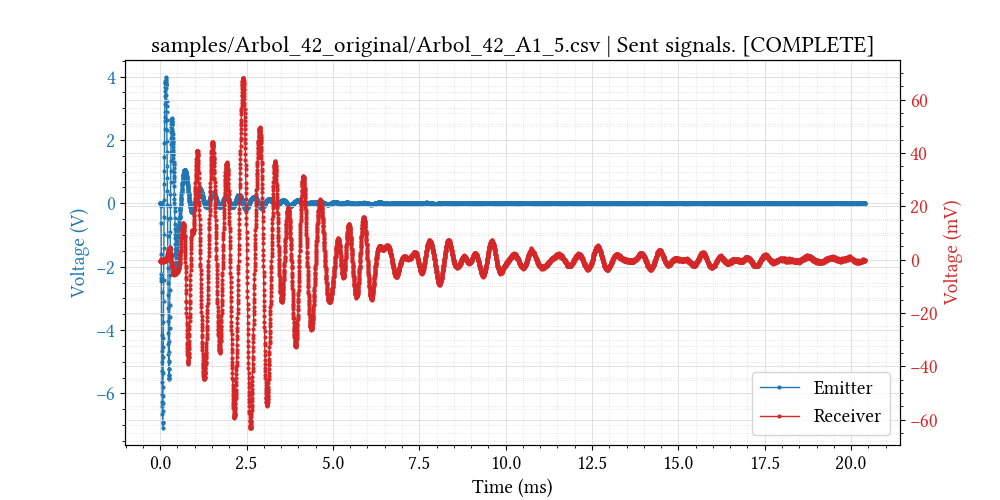

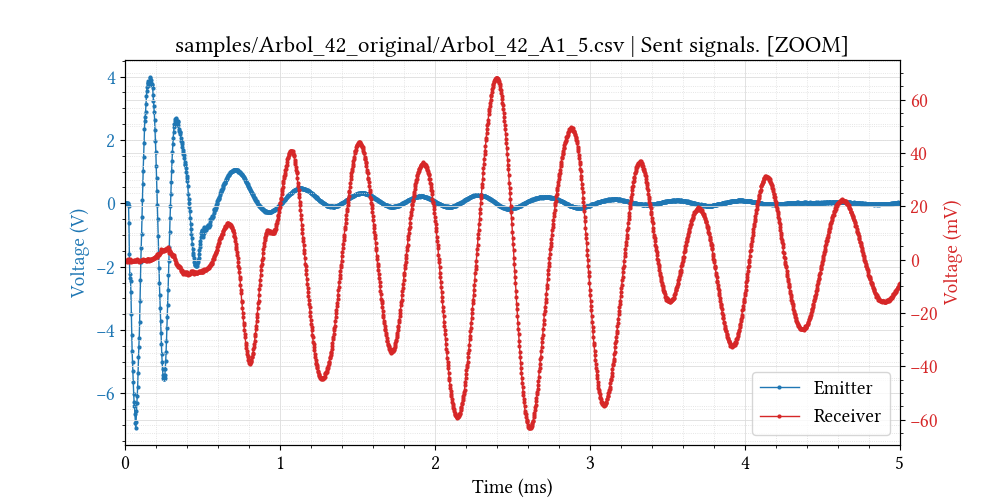

In [11]:
# Path to the .csv samples file. (a .bin file will be saved on the same path)
# Expects a plain text file with '.' as decimal separator and ',' delimiter.
path_to_file = "samples/Arbol_42_original/Arbol_42_A1_5.csv"

# Sets the configuration and sends samples to the arbitrary waveform generator.
# Channel 1 will be the Emitter
# Channel 2 will be the Receiver
send_samples_file(path_to_file, 
                  sample_init=2900,  # These parameters sets the init and end of 
                  sample_end=10900)  # the sample vector to send. 
                                     # Must not be longer than 16000

# Burst (trigger individual signal periods)

By default, the signal generator outputs continuos signal periods. 

This commands tell the device to only output a single period when certain conditions are met. In this case, when we trigger it manually.

By limitations of this method (can't trigger both channels true simultaneously), it's possible that signals are a bit delayed one of another. You can avoid this by setting a small (ms, us or ns) delay on channel 1.

In [14]:
# Deactivates burst
Generador.burst_config(channel=1, state="OFF")
Generador.burst_config(channel=2, state="OFF")

In [13]:
# Activates burst and sends a manual trigger to both channels
# This is what you want to execute if are outputting TIK singals
Generador.burst_send_manual_both_channels()

In [17]:
# Activates both channels burst mode and sends a manual trigger for both
# channels, but with a configurable delay on every channel.
# This can be used to test if TIK equipment detects the arrival time correctly.

emitter_delay_s = 100e-6  # Emitter delay in seconds. Moves signal closer to each other.
receiver_delay_s = 0  # Receiver delay. in seconds. Moves signals away from each other.

Generador.burst_send_manual_both_channels(ch1_trigger_delay=emitter_delay_s,
                                          ch2_trigger_delay=receiver_delay_s)

--- 

# Generator repair process (untraslated).

Parece que esta fuente en particular tiene un problema con ciertas versiones de su firmware que hacen que se llene el almacenamiento con ficheros temporales tipo logs, y al saturarse la memoria no puede arrancar el sistema.

Síntomas: sin previo aviso, de un encendido para otro, no arranca. La pantalla muestra el logo de siglent pero se apaga y no vuelve a aparecer. No reacciona a los botones frontales, ni hay nada a la salida de los  

La tolerancia especificada por el fabricante en los raíles es del 5%.

### Main Board.

Es probablemente donde se halla el error porque se comunica directamente con la pantalla por un ribbon cable.
Al encenderse, el LED HL1 (ARM LED) se enciende con poca intensidad y luego se iluminan más intensamente.

Al estabilizarse, el LED HL1 (ARM LED) se enciende y parpadea dos veces rápido una vez cada 1.26 segundos (0.79 Hz)



#### Test Points:

Comprobación de voltajes DC.

- **TP87** Esperado: 5 V. Lectura: 5.06 V
- **TP88** Esperado: 3.3 V. Lectura: 3.37 V
- **TP86** Esperado: 16 V. Lectura: 14.93 V -> discrepancia del 6.7 %.

#### CLK

- **TP22** Reloj del chip ARM, CLK 25 MHz. Lectura: 24.88 MHz.

### Channel Board.

El LED D1 (FPGA_LED) Parpadea con frecuencia de 1 Hz (0.98 Hz medido con osciloscopio).

#### Test Points:

Comprobación de voltajes DC

- **TP13 VCC5V**: Lectura: 4.95 V (tercera medida, no hace buen contacto el pad) <!-- **<font color='red'>10 mV</font>** -->
- **TP11 VCC3V3**: Lectura: 3.34 V (no hace buen contacto al principio)
- **TP15 VCC1V2**: Lectura: 1.248 V
- **TP18 AVEE-5V**: Lectura: -5.03 V
- **TP16 AVEE5V**: Lectura: 4.98 V
- **TP12 AVCC15V**: Lectura: 15.20 V
- **TP14 AVEE-15V**: Lectura: -14.97 V

#### CLK

- **R19**: Reloj del chip FPGA, CLK 25 MHz. Lectura: (osciloscopio): 24.94 MHz (es un buen resultado teniendo en cuenta la interferencia de la sonda del osciloscopio)

## Solución:

Parece ser un bug del sistema. La solución era reinstalar el sistema de la fuente con una imagen de recuperación, se puede encontrar en la carpeta `firmware` de este notebook. Luego, actualizar a la última versión del firmware disponible.-

---

# Residual code, experiments. Notes, troubles, debugging and other details from the development of the library (untraslated).

## Pruebas

Hay dos opciones, o bien usar la librería de vxi11 o pyVISA. Son equivalentes. El código en vxi11 es más sencillo y directo. Sin embargo, para la librería debemos usar PyVISA por cierta funcionalidad que no tiene VXI11 (o por lo menos no está documentada) al enviar muestras.

In [4]:
IP = "192.168.1.178"
SGD_VISA = visa.ResourceManager('@py').open_resource(f'TCPIP0::{IP}::inst0::INSTR')
print("SGD found: " + SGD_VISA.query('*IDN?').strip())

SGD found: Siglent Technologies,SDG1062X,SDG1XCAD1R3295,1.01.01.33R1B6


In [47]:
SGD_VISA.write_termination

'\r\n'

In [4]:
#SGD_vxi11 = vxi11.Instrument("192.168.1.101")
#print("SGD found: " + SGD_vxi11.ask("*IDN?"))

SGD found: Siglent Technologies,SDG1062X,SDG1XCAD1R3295,1.01.01.22R5


In [5]:
#SGD_vxi11.ask("*RST")

''


## Lectura de datos de árboles en .csv, conversión a binario, guardado en fichero .bin y envío de muestras al generador


In [5]:
import numpy as np

filename = "samples/Arbol_42_original/Arbol_42_A1_1.csv"
t, ch_a, ch_b = np.loadtxt(filename, delimiter=',', unpack=True, skiprows=3)

# Ajustes de unidades
time_offset = 1e-3 * abs(t[1])  # offset para eliminar tiempo negativo
t = t * 1e-3 + time_offset  # ms to s, empezar en t0 = 0
ch_b = ch_b * 1e-3  # mV to V

L = len(ch_a)
Ts = t[-1] / L  # periodo de muestreo
Fs = int(1/Ts)  # frecuencia de muestreo

print(f"Frecuencia de muestreo: {Fs/1e3:.3f} kHz")

sample_init = 2900
sample_end = 10900
sample_num = sample_end - sample_init

t2 = np.arange(0, sample_num, 1) * Ts  # nuevo vector temporal
tmax = sample_num * Ts  # tiempo máximo, final del vector
freq_rep = int(1/tmax)  # frecuencia de repetición de la señal completa

emitter = ch_a[sample_init:sample_end]
receiver = ch_b[sample_init:sample_end]

print(f"Tiempo máximo: {tmax*1e3:.3f} ms; Frecuencia de repetición de la señal: {freq_rep:.3f} Hz")
print(f"longitud de muestras: t2: {len(t2)}, emitter: {len(emitter)}, receiver: {len(receiver)}")

vmax_emitter = max(abs(emitter))
vmax_receiver = max(abs(receiver))
print(f"vmax,emitter: {vmax_emitter:.3f} V\nvmax,receiver: {vmax_receiver*1e3:.3f} mV")
print(f"2*vmax,emitter: {2*vmax_emitter:.3f} V\n2*vmax,receiver: {2*vmax_receiver*1e3:.3f} mV")

vpp_emitter = max(emitter) - min(emitter)
vpp_receiver = max(receiver) - min(receiver)
print(f"vpp,emitter: {vpp_emitter:.3f} V\nvpp,receiver: {vpp_receiver*1e3:.3f} mV")

Frecuencia de muestreo: 392.196 kHz
Tiempo máximo: 20.398 ms; Frecuencia de repetición de la señal: 49.000 Hz
longitud de muestras: t2: 8000, emitter: 8000, receiver: 8000
vmax,emitter: 7.221 V
vmax,receiver: 69.039 mV
2*vmax,emitter: 14.443 V
2*vmax,receiver: 138.078 mV
vpp,emitter: 11.063 V
vpp,receiver: 128.678 mV


In [8]:
emitter_intC2 = Generador.samples_float_to_int_C2(emitter)
emitter_bytes = Generador.samples_int_C2_to_bytes(emitter_intC2)

emitter_bytearray = b""
for item in emitter_bytes:
    emitter_bytearray += item
emitter_binascii = emitter_bytearray.decode("latin1")

print(emitter_intC2[-20:])
print(emitter_bytes[-20:])
print(emitter_bytearray[-40:])
print(emitter_binascii[-40:])

[0, 65508, 65508, 0, 22, 0, 65508, 65508, 0, 65486, 65508, 0, 0, 22, 44, 22, 65508, 66, 0, 0]
[b'\x00\x00', b'\xe4\xff', b'\xe4\xff', b'\x00\x00', b'\x16\x00', b'\x00\x00', b'\xe4\xff', b'\xe4\xff', b'\x00\x00', b'\xce\xff', b'\xe4\xff', b'\x00\x00', b'\x00\x00', b'\x16\x00', b',\x00', b'\x16\x00', b'\xe4\xff', b'B\x00', b'\x00\x00', b'\x00\x00']
b'\x00\x00\xe4\xff\xe4\xff\x00\x00\x16\x00\x00\x00\xe4\xff\xe4\xff\x00\x00\xce\xff\xe4\xff\x00\x00\x00\x00\x16\x00,\x00\x16\x00\xe4\xffB\x00\x00\x00\x00\x00'
  äÿäÿ     äÿäÿ  Îÿäÿ     ,  äÿB     


In [9]:
receiver_intC2 = Generador.samples_float_to_int_C2(receiver)
receiver_bytes = Generador.samples_int_C2_to_bytes(receiver_intC2)

receiver_bytearray = b""
for item in receiver_bytes:
    receiver_bytearray += item
receiver_binascii = receiver_bytearray.decode("latin1")

print(receiver_intC2[-20:])
print(receiver_bytes[-20:])
print(receiver_bytearray[-40:])
print(receiver_binascii[-40:])

[0, 0, 0, 65362, 0, 65362, 0, 0, 65362, 0, 0, 0, 0, 65362, 0, 65362, 0, 65362, 65188, 0]
[b'\x00\x00', b'\x00\x00', b'\x00\x00', b'R\xff', b'\x00\x00', b'R\xff', b'\x00\x00', b'\x00\x00', b'R\xff', b'\x00\x00', b'\x00\x00', b'\x00\x00', b'\x00\x00', b'R\xff', b'\x00\x00', b'R\xff', b'\x00\x00', b'R\xff', b'\xa4\xfe', b'\x00\x00']
b'\x00\x00\x00\x00\x00\x00R\xff\x00\x00R\xff\x00\x00\x00\x00R\xff\x00\x00\x00\x00\x00\x00\x00\x00R\xff\x00\x00R\xff\x00\x00R\xff\xa4\xfe\x00\x00'
      Rÿ  Rÿ    Rÿ        Rÿ  Rÿ  Rÿ¤þ  


### Lectura del fichero y envío de los datos

In [213]:
import os

arbol_file = str(filename.split('/')[-1]).split('.')[0]
save_path = f"samples/Arbol_42_bin/{arbol_file}"
try:
    os.mkdir(save_path)
except FileExistsError:
    print("¡Sobreescribiendo datos!")
print(f"save_path = {save_path}")

# Canal A - Emisor
with open(f"{save_path}/{arbol_file}_e.bin", "wb") as f:
    f.write(emitter_bytearray)
# Canal B - Receptor
with open(f"{save_path}/{arbol_file}_r.bin", "wb") as f:
    f.write(receiver_bytearray)
    
with open(f"{save_path}/{arbol_file}_e.bin", "rb") as f:
    emitter_bindata = f.read().decode("latin1")
with open(f"{save_path}/{arbol_file}_r.bin", "rb") as f:
    receiver_bindata = f.read().decode("latin1")

print("\n")
print(emitter_bindata[-40:])
print(receiver_bindata[-40:])

print(f"longitud de datos: {len(emitter_bindata)}")

¡Sobreescribiendo datos!
save_path = samples/Arbol_42_bin/Arbol_42_A1_1


  äÿäÿ     äÿäÿ  Îÿäÿ     ,  äÿB     
      Rÿ  Rÿ    Rÿ        Rÿ  Rÿ  Rÿ¤þ  
longitud de datos: 16000


### Problema con el envío de muestras: Muestras adicionales indeseadas al final de la señal.

Parece no enterarse de cuando termina el envío de muestras cuando son un número grande. Si envías por ejemplo 8 muestras, el dispositivo acepta los datos y los guarda en un fichero, pero si se envían grandes cantidades de muestras en binario, parece no captar el final de la secuencia y por ello se envía un comando vacío con el carácter de parada. Si no, incorpora al archivo de muestras el siguiente comando que se ejecute. Es muy extraño y desconozco la causa.

Se puede apreciar claramente si se envía una señal y no se ejecuta nada más. Si se envían pocas muestras y no se envía ningún otro comando, si se accede al menú de señales arbitrarias de usuario aparece el archivo creado. Sin embargo si se hace exactamente lo mismo con una señal de longitud significativa (por encima de las 500 ó 1000 muestras según mis pruebas) no aparece el archivo hasta que otro comando es enviado porque el dispositivo cree que la transferencia no ha acabado.

Es irrelevante indicar la longitud de los datos, el aparato ignora el parámetro.

En el ejemplo del fabricante, usa un delimitador de envío (`write_termination`) igual a un string vacío: `""`; por defecto la librería usa `"\r\n"`. Parece que los comandos usuales no tienen problema con ningún delimitador, pero sí influye en el envío de muestras. Independientemente del delimitador, la fuente confunde el siguiente comando con muestras. El manual no indica nada en este aspecto.

In [215]:
emitter_wave_name = f"{arbol_file}_e"
Generador.arb_send_samples(channel=1,
                           wave_name=emitter_wave_name,
                           freq=freq_rep,
                           amp=vmax_emitter,
                           bin_data=emitter_bindata,
                           len_data=len(emitter_bindata))
Generador.write("\r\n")
Generador.arb_output(channel=1, wave_name=f"{emitter_wave_name}")

bytes: 16080


28

In [14]:
Generador.arb_sample_rate(channel=1, sample_rate=400e3, interpolation="LINE", sample_rate_mode="TARB")

44

In [15]:
Generador.arb_sample_rate(channel=1, sample_rate=400e3, interpolation="LINE", sample_rate_mode="DDS")

43

In [218]:
receiver_wave_name = f"{arbol_file}_r"
Generador.arb_send_samples(channel=2,
                           wave_name=receiver_wave_name, 
                           freq=freq_rep, 
                           amp=vmax_receiver, 
                           bin_data=receiver_bindata,
                           len_data=len(receiver_bindata))
Generador.write("\r\n")
Generador.arb_output(channel=2, wave_name=f"{receiver_wave_name}")

bytes: 16080


28

In [11]:
Generador.arb_sample_rate(channel=2, sample_rate=Fs, interpolation="HOLD", sample_rate_mode="TARB")

42

In [202]:
# Selección de la muestra a la salida
Generador.arb_output(channel=2, wave_name=f"{receiver_wave_name}")

28

NameError: name 't2' is not defined

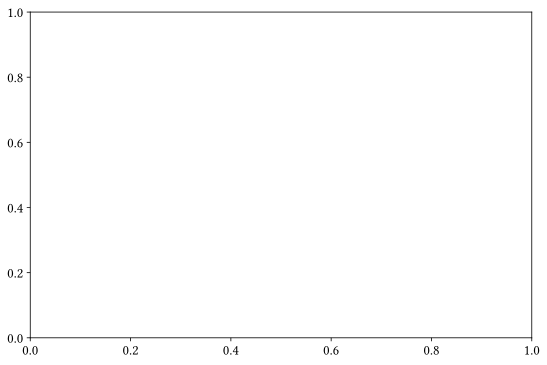

In [2]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

from matplotlib import pyplot as plt

plt.rcParams["font.family"] = "Libertinus Serif"
plt.rcParams['font.size'] = 14
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Libertinus Serif'
plt.rcParams['mathtext.it'] = 'Libertinus Serif:italic'
plt.rcParams['mathtext.bf'] = 'Libertinus Serif:bold'

fig, ax = plt.subplots(figsize=[9, 6])
plot_1 = plt.plot(t2, emitter, linestyle="solid", marker=".", markersize=2, linewidth=1, label=r'Emitter', color='tab:blue')

ax.grid(True, which='major', color='#DDDDDD', linestyle='-', linewidth=0.6)
ax.grid(True, which='minor', color='#DDDDDD', linestyle=':', linewidth=0.6)
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
ax.tick_params(axis ='y', labelcolor = 'tab:blue')
ax.set_ylabel(r'Voltaje (V)', color='tab:blue')
ax.minorticks_on()
ax.set_ylim([-8, 4])

ax2 = ax.twinx()
plot_2 = plt.plot(t2, receiver, linestyle="solid", marker=".", markersize=2, linewidth=1, label=r'Receiver', color='tab:red')

ax2.ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
ax2.tick_params(axis ='y', labelcolor = 'tab:red')
ax2.set_ylabel(r'Voltaje (V)', color='tab:red')
ax2.minorticks_on()
ax2.set_ylim([-0.1, 0.1])

lns = plot_1 + plot_2
labels = [l.get_label() for l in lns]
plt.legend(lns, labels, loc="lower right")
plt.xlabel("tiempo (s)")
plt.xlim([0, tmax/5])

NameError: name 't2' is not defined

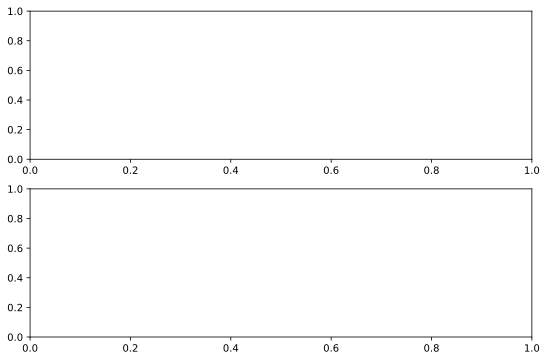

In [ ]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

from matplotlib import pyplot as plt
import numpy as np

fig = plt.figure(figsize=[9, 6])
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(t2, np.array(emitter_int), linestyle="solid", linewidth=1, color="tab:blue")
ax2.plot(t2, np.array(receiver_int), linestyle="solid", linewidth=1, color="tab:blue")

# Están en complemento a dos y con bytes desordenados, no saldrá la señal tal cual

### Envío de una señal arbitraria de prueba

In [44]:
# Conversión de hexadecimal a entero, interpretando complemento a dos, con signo
def twosComplement_hex(hexval):
    bits = 16 # Number of bits in a hexadecimal number format
    val = int(hexval, bits)
    if val & (1 << (bits-1)):
        val -= 1 << bits
    return val

In [57]:
# convertimos de vuelta a hex para confirmar que el método es correcto.
def twosComplement_int(intvector):
    n_points = 2 ** 16
    samples_hex = []
    for sample in intvector:
        if sample < 0:
            samples_hex.append(f"{(sample + n_points):04x}")
        else:
            samples_hex.append(f"{(sample):04x}")
    return samples_hex

In [58]:
wave_points_hex = ["8000", "8000", "f000", "f000", "0000", "0000", "1000", "1000", "7fff", "7fff"]
wave_points_int = [twosComplement_hex(point) for point in wave_points_hex]  # son valores adecuados que buscamos
samples_hex = twosComplement_int(wave_points_int)  # convertimos de vuelta a hex para confirmar que el método es correcto.

print(f"Vector de enteros: \t{wave_points_int}")
print(f"Vector hex original: \t{wave_points_hex}")
print(f"Vector reconvertido: \t{samples_hex}")

Vector de enteros: 	[-32768, -32768, -4096, -4096, 0, 0, 4096, 4096, 32767, 32767]
Vector hex original: 	['8000', '8000', 'f000', 'f000', '0000', '0000', '1000', '1000', '7fff', '7fff']
Vector reconvertido: 	['8000', '8000', 'f000', 'f000', '0000', '0000', '1000', '1000', '7fff', '7fff']


#### IMPORTANTE: VALOR DE LAS MUESTRAS

Por ensayo y error, usando el programa de ejmplo de Siglent, aunque el datasheet diga que la resolución vertical son 14 bits, entiende **16 bits** en muestras arbitrarias.
Por tanto, **los valores máximos y mínimos NO SON -8192 y +8191**, sino:

- máx: `0x7fff` ->`+32767` (2^(16) - 1)
- mín: `0x8000` ->`-32768` (- 2^(16-1))

In [62]:
# Pasando el vector de muestras enteras a float, simulando una señal real
# Test de los métodos de la clase.

amp = 2
n_bits = 16
n_points = 2 ** (n_bits - 1) -1
factor = n_points / amp

# int to float
wave_points_float = [point / factor for point in wave_points_int]  # vector float, con signo.
print(wave_points_float)  # Debería corresponderse con la amplitud a la salida

[-2.000061037018952, -2.000061037018952, -0.250007629627369, -0.250007629627369, 0.0, 0.0, 0.250007629627369, 0.250007629627369, 2.0, 2.0]


In [63]:
# Conversión de muestras float a int C2
samples_intC2 = Generador.samples_float_to_int_C2(samples_float=wave_points_float, amp=2)
print(samples_intC2)

[32768, 32768, 61440, 61440, 0, 0, 4096, 4096, 32767, 32767]


In [64]:
# Conversión de muestras int C2 a binascii
samples_binascii = Generador.samples_int_C2_to_bytes(samples_int_C2=samples_intC2)
print(samples_binascii)

[b'\x00\x80', b'\x00\x80', b'\x00\xf0', b'\x00\xf0', b'\x00\x00', b'\x00\x00', b'\x00\x10', b'\x00\x10', b'\xff\x7f', b'\xff\x7f']


In [65]:
# Guardado de la señal
bin_data = b""
for item in samples_binascii:
    bin_data += item
print(bin_data)

wave_name = "testsignal1"
with open(f"{wave_name}.bin", "wb") as f:
    f.write(bin_data)

b'\x00\x80\x00\x80\x00\xf0\x00\xf0\x00\x00\x00\x00\x00\x10\x00\x10\xff\x7f\xff\x7f'


In [66]:
# Carga la señal.
with open(f"{wave_name}.bin", "rb") as f:
    data = f.read().decode("latin1")
print(data)
len(data)

   ð ð      ÿÿ


20

In [67]:
# Envío del vector de muestras de prueba
Generador.arb_send_samples(channel=1,
                           wave_name=wave_name, 
                           freq=100,
                           amp=amp, 
                           bin_data=data,
                           len_data=len(data))

bytes: 80


80

In [71]:
# Selección del tipo de muestreo
# No parece que haga nada...
Generador.arb_sample_rate(channel=1, sample_rate="", interpolation="LINE", sample_rate_mode="TARB")

36

In [72]:
# Selección de la muestra a la salida
Generador.arb_output(channel=1, wave_name=wave_name)  
# Funciona correctamente. Deberíamos ver a la salida la función de más abajo

24

Funciona correctamente. Debería verse esta señal en el generador y en el osciloscopio:

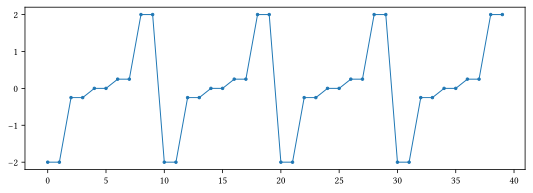

In [73]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

from matplotlib import pyplot as plt
import numpy as np

onda_repetida = []
onda_repetida.extend(wave_points_float)
onda_repetida.extend(onda_repetida)
onda_repetida.extend(onda_repetida)

fig, ax = plt.subplots(figsize=[9, 3])
plot_1 = plt.plot(np.arange(len(onda_repetida)), onda_repetida, linestyle="solid", marker=".", markersize=5, linewidth=1, color='tab:blue')

# Otras pruebas. Experimentos. (untraslated)

### Pruebas de codificación binaria

In [36]:
x = 56
print(f"{x:04x}")  # imprimir en hexadecimal con padding de 4 caracteres.

# No funciona si es negativo. Hay que convertir los datos de decimal con signo a
# decimal sin signo estilo complemento a dos.
# Para ello se suma a la cantidad 2 ** n_bits el valor negativo: 2^16 + (-8196) = 57340

x = -8196
y = 2 ** 16 + x
y

0038


57340

In [37]:
import numpy as np  # Usado para experimentar. la función no depende de numpy.

n_bits = 12  # Nº de bits del DAC del generador
n_ptos = 2**n_bits  # nº de cuantos del DAC
v_max = 5  # Voltaje máximo absoluto, de la señal
factor = n_ptos / (v_max * 2)

samples_f = np.random.uniform(-v_max, v_max, size=(1, 10))  # Vector de prueba
samples_f = samples_f[0]

print(samples_f)

[ 0.09001548  4.53724853  1.87075963 -0.64251741  2.43947107  3.47376636
  0.70263805 -3.39314602  4.85104018 -0.39021399]


In [38]:
samples_b_func = Generador.samples_to_bin(samples_f, v_max, byteorder="little")
print(samples_b_func)

AttributeError: 'SDG1062X' object has no attribute 'samples_to_bin'

In [ ]:
from math import ceil
import binascii

v_max = 1

n_bits = 16
n_bytes = ceil(n_bits / 8)  # nº de bytes en los que codificar los datos
byteorder = "little"
n_points = 2 ** n_bits  # nº de cuantos del DAC
factor = n_points / v_max  # Factor de escalado de las muestras

samples_int_C2 = [-8192, -5461, 8196, 0, 1]

# samples_int = [int(round(sample * factor)) for sample in samples_float]
# samples_int_C2 = [n_points + sample for sample in samples_int if sample < 0]
samples_hex = [] 

for sample in samples_int_C2:
    if sample < 0:
        samples_hex.append(f"{(sample + n_points):04x}")
    else:
        samples_hex.append(f"{(sample):04x}")

print(samples_hex)
        
samples_bytes = [sample[2:4] + sample[:2] for sample in samples_hex]
print(samples_bytes)
samples_bytes = [binascii.unhexlify(sample) for sample in samples_bytes]
print(samples_bytes)

In [ ]:
n_bits = 16
n_bytes = ceil(n_bits / 8)  # nº de bytes en los que codificar los datos
byteorder = "little"
n_points = 2 ** n_bits  # nº de cuantos del DAC
factor = n_points / v_max  # Factor de escalado de las muestras

samples_int = wave_points

#samples_int = [int(round(sample * factor)) for sample in samples_float]
samples_int_C2 = [n_points + sample for sample in samples_int if sample < 0]
samples_hex = [f"{sample:04x}" for sample in samples_int_C2]
samples_hex

## Código de ejemplo de Siglent, ligeramente modificado

In [ ]:
import binascii
import pyvisa as visa
import random
import time


# 0xE000: 1110 0000 0000 0000: decimal (complemento a dos): -8192
# 0xF000: 1111 0000 0000 0000: decimal (C2): -4096
# wave_int_samples = 
#wave_data = ["8000", "8000", "f000", "f000", "0000", "0000", "1000", "1000", "7fff", "7fff"]
wave_data = [0x8000, 0x8000, 0xf000, 0xf000, 0x0000, 0x0000, 0x1000, 0x1000, 0x7fff, 0x7fff]
wave_points = []
wave_points += wave_data          # En entero PYTHON LO INTERPRETA SIN SIGNO.

print(wave_data)
print(wave_points)
print(len(wave_points))
 
def create_wave_file():
    """create a file"""
    f = open("wave1.bin", "wb")
    for a in wave_points:
        b = hex(a)                # En hexadecimal
        b = b[2:]                 # Elimina el '0x'. También desaparecen los ceros a la izquierda.
        len_b = len(b)            # Longitud de la muestra hexadecimal. 
        if (0 == len_b):
            b = '0000'            # Si está vacío
        elif (1 == len_b):
            b = '000' + b         # Sólo 1 dígito
        elif (2 == len_b):
            b = '00' + b          # 2 dígitos
        elif (3 == len_b):
            b = '0' + b           # 3 dígitos. Si tiene 4, no importa.
        b = b[2:4] + b[:2]        # change big-endian to little-endian. Altera el orden de los bytes.
        c = binascii.unhexlify(b) # Hexadecimal integer to ASCii encoded string
        f.write(c)
        print(c)
    f.close()
    
def send_wave_data(dev):
    """send wave1.bin to the device"""
    f = open("wave1.bin", "rb")    #wave1.bin is the waveform to be sent
    data = f.read().decode("latin1")
    print('write class:', type(data))
    print('write bytes:',len(data))
    dev.write_termination = ''
    dev.write("C1:WVDT WVNM,wave1,FREQ,2000.0,AMPL,4.0,OFST,0.0,PHASE,0.0,WAVEDATA,%s"%(data),encoding='latin1')    #"X" series (SDG1000X/SDG2000X/SDG6000X/X-E)&amp;amp;lt;/pre&amp;amp;gt;
    dev.write("C1:ARWV NAME,wave1")
    f.close()
    return data

In [ ]:
device_resource = 'TCPIP0::192.168.1.101::inst0::INSTR'

rm=visa.ResourceManager()
device=rm.open_resource(device_resource, timeout=50000, chunk_size = 24*1024*1024)
create_wave_file()
send=send_wave_data(device) 

In [ ]:
2 ** 14

In [ ]:
wave_points_int_rec = [twosComplement_hex(point) for point in samples_hex]  # confirmamos que sí son valores adecuados que buscamos
print(wave_points_int_rec)

In [ ]:
wave_points_hex_little = [point[2:4] + point[:2] for point in wave_points_hex]  # little-endian
print(wave_points_hex_little)

wave_points_bin = [binascii.unhexlify(point) for point in wave_points_hex_little]  # binario
print(wave_points_bin)

In [ ]:
wave_points_int_rec = [twosComplement_hex(point) for point in wave_points_hex_little]  # confirmamos que sí son valores adecuados que buscamos
print(wave_points_int_rec)

In [ ]:
Generador.arb_send_samples(channel=1,
                           wave_name=f"wave1_example", 
                           freq=2000, 
                           amp=4, 
                           wave_data=bindata)